In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["animation.html"] = 'html5'

import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal

def remove_frame():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

# Multivariate normal

$$x \sim \mathcal{N}(\mu, \Sigma)$$
with 
- $\mu \in \mathbb{R}^d$
- $\Sigma \in \mathbb{R}^{d \times d}$, semi-definitive positive.

The probability density function is
$$p(x) = \frac{1}{(2\pi)^{\frac{d}{2}}|\Sigma|^{\frac{1}{2}}} \exp(-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu)$$

In [18]:
mu1 = 0.0
mu2 = 0.0
mu = np.array([mu1, mu2])
sigma11 = 1.0
sigma12 = 0.3
sigma22 = 1.0
sigma = np.array([[sigma11, sigma12], [sigma12, sigma11]])
p = multivariate_normal(mean=mu, cov=sigma)

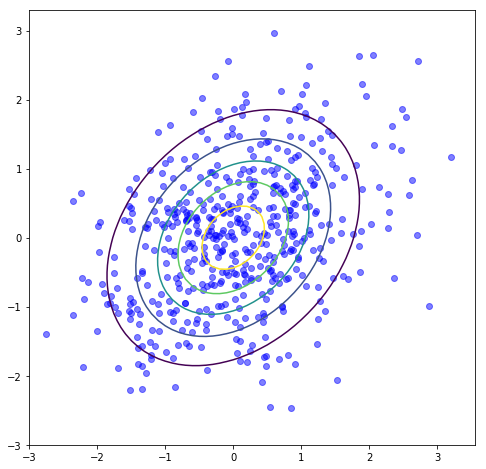

In [21]:
x1s = np.arange(-3.0, 3.0, 0.1)
x2s = np.arange(-3.0, 3.0, 0.1)
X1, X2 = np.meshgrid(x1s, x2s)
Z = p.pdf(np.hstack([X1.reshape(-1,1), X2.reshape(-1,1)])).reshape(X1.shape)
plt.contour(X1, X2, Z, 5)

xs = p.rvs(500)
plt.scatter(xs[:, 0], xs[:, 1], c="b", marker="o", alpha=0.5)
plt.show()

How does one can actually implement the `rvs` method?

# Gibbs sampling

Assume a bivariate normal distribution ($d=2$) on $X_1$ and $X_2$. What would be Bayesian network for this distribution? What if $d \geq 2$?

For Gibbs sampling we need to know the univariate conditional densities $p(x_1|x_2)$ and $p(x_1|x_2)$. In the case of a joint multivariate normal, its conditional distribution is also a multivariate normal:

- $x_1|x_2 \sim \mathcal{N}(\mu_1 + \frac{\sigma_{12}}{\sigma_{22}}(x_2-\mu_2), \sigma_{11}-\frac{\sigma_{12}^2}{\sigma_{22}})$
- $x_2|x_1 \sim \mathcal{N}(\mu_2 + \frac{\sigma_{12}}{\sigma_{11}}(x_1-\mu_1), \sigma_{22}-\frac{\sigma_{12}^2}{\sigma_{11}})$

where $\sigma_{12}$ is the covariance between $X_1$ and $X_2$. These are univariate and we can use their known inverse CDFs to draw samples from them.

In [22]:
# Random starting point in [-3,3]x[-3,3]
x0 = np.random.rand(2) * 6.0 - 3.0
# x0 = np.array([-2.0, 2.0])
x0

array([-1.24475162, -0.03085175])

In [23]:
xs = [x0]

for j in range(500):
    newx = xs[-1].copy()
    
    # Same as in the course
    if j % 2 == 0:
        p_x1_given_x2 = norm(mu1 + sigma12/sigma22*(newx[1]-mu2),
                             (sigma11 - sigma12**2/sigma22)**0.5)
        newx[0] = p_x1_given_x2.rvs(1)
        
    else:
        p_x2_given_x1 = norm(mu2 + sigma12/sigma11*(newx[0]-mu1),
                             (sigma22 - sigma12**2/sigma11)**0.5)
        newx[1] = p_x2_given_x1.rvs(1)
        
#     # Resample all variables
#     p_x1_given_x2 = norm(mu1 + sigma12/sigma22*(newx[1]-mu2),
#                          (sigma11 - sigma12**2/sigma22)**0.5)
#     newx[0] = p_x1_given_x2.rvs(1)
#     p_x2_given_x1 = norm(mu2 + sigma12/sigma11*(newx[0]-mu1),
#                          (sigma22 - sigma12**2/sigma11)**0.5)
#     newx[1] = p_x2_given_x1.rvs(1)
        
    xs.append(newx)
    
xs = np.array(xs)

In [24]:
%%capture
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig = plt.figure()
ax = plt.axes(xlim=(-3,3), ylim=(-3,3))
scatter = ax.scatter([], [], c="b", marker="o", alpha=0.33)
vline = ax.axvline(-5.0, c="r")
hline = ax.axhline(-5.0, c="r")

def init():
    x1s = np.arange(-3.0, 3.0, 0.1)
    x2s = np.arange(-3.0, 3.0, 0.1)
    X1, X2 = np.meshgrid(x1s, x2s)
    Z = p.pdf(np.hstack([X1.reshape(-1,1), X2.reshape(-1,1)])).reshape(X1.shape)
    ax.contour(X1, X2, Z, 5)

    scatter.set_offsets([])
    
    return scatter,    

def update(frame_number):
    scatter.set_offsets(xs[:frame_number+1])
    vline.set_xdata(xs[frame_number, 0])
    hline.set_ydata(xs[frame_number, 1])
    
    return scatter, 

In [10]:
anim = FuncAnimation(fig, update, init_func=init, interval=200, frames=len(xs))
anim

In [25]:
np.mean(xs, axis=0)

array([-0.04971718, -0.06064708])

In [31]:
np.cov(xs.T)

array([[1.02184076, 0.24078665],
       [0.24078665, 0.95500176]])

- What if $\sigma_{12} \to 1$?
- Are those samples iid? How can we reduce correlations between samples?